# Построение рекомендаций


## TF-IDF на тегах и жанрах


In [2]:
!pip install wget

In [3]:
import wget
import zipfile
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
dataset = 'ml-latest-small'

In [5]:
url = f'https://files.grouplens.org/datasets/movielens/{dataset}.zip'
wget.download(url, 'dataset_po_filmam.zip')

'dataset_po_filmam (6).zip'

In [6]:
with zipfile.ZipFile("dataset_po_filmam.zip", "r") as zip_ref:
  zip_ref.extractall()

In [7]:
links = pd.read_csv(f'./{dataset}/links.csv')
links.name = 'links'

In [8]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


Аналогично для остальных файлов

In [9]:
movies = pd.read_csv(f"./{dataset}/movies.csv")
movies.name = 'movies'
ratings = pd.read_csv(f"./{dataset}/ratings.csv")
ratings.name = 'ratings'
tags = pd.read_csv(f"./{dataset}/tags.csv")
tags.name = 'tags'

Поиск дубликатов

In [10]:
def dubli(dataset) -> None:
  print(dataset.name)
  print("С чем работаем:")
  dataset.info()
  print(f'Что по дублям:{dataset.duplicated().sum()}')
  print()

In [11]:
dubli(links)

links
С чем работаем:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
Что по дублям:0



In [12]:
dubli(movies)

movies
С чем работаем:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
Что по дублям:0



In [13]:
dubli(ratings)

ratings
С чем работаем:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
Что по дублям:0



In [14]:
dubli(tags)

tags
С чем работаем:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
Что по дублям:0



## Users

In [15]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


Уникальные

In [16]:
unique_users = tags["userId"].value_counts()

In [17]:
print(unique_users)
print(f"Число уникальных юзеров: {len(unique_users)}")

userId
474    1507
567     432
62      370
599     323
477     280
424     273
537     100
125      48
357      45
318      41
184      35
573      31
193      20
18       16
119      14
336      10
2         9
305       8
606       7
327       7
166       6
462       5
419       5
356       5
103       5
21        4
289       4
291       4
435       4
132       4
506       3
533       3
319       3
439       3
610       3
509       3
205       3
49        3
177       3
112       3
226       3
487       3
513       3
63        2
76        2
341       2
520       2
256       2
106       2
138       2
288       1
274       1
161       1
167       1
7         1
300       1
543       1
600       1
Name: count, dtype: int64
Число уникальных юзеров: 58


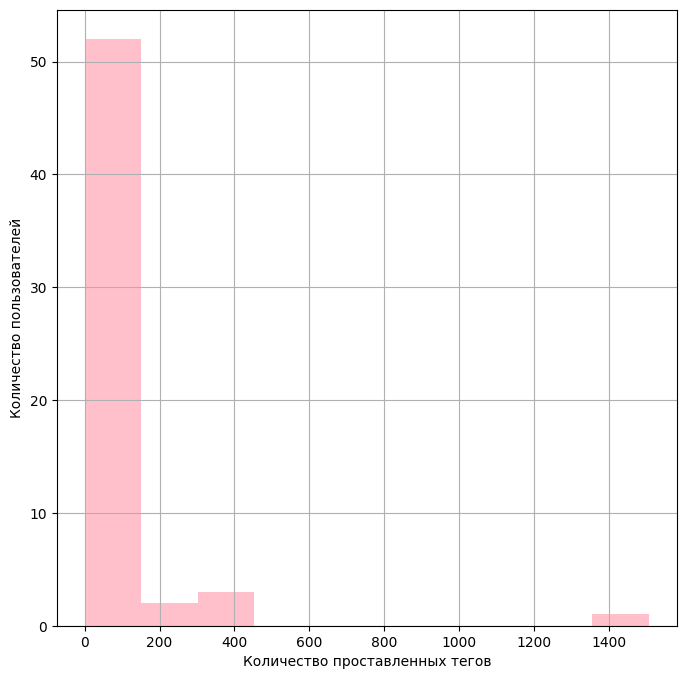

In [18]:
plt.figure(figsize=[8,8])
unique_users.hist(color = "pink")
plt.xlabel("Количество проставленных тегов")
plt.ylabel("Количество пользователей")
plt.show()

Items

In [19]:
unique_items = tags["movieId"].value_counts()

In [20]:
print(unique_items)
print(f'Число уникальных айтемов: {len(unique_items)}')

movieId
296     181
2959     54
924      41
293      35
7361     34
       ... 
2186      1
2167      1
2139      1
2122      1
2243      1
Name: count, Length: 1572, dtype: int64
Число уникальных айтемов: 1572


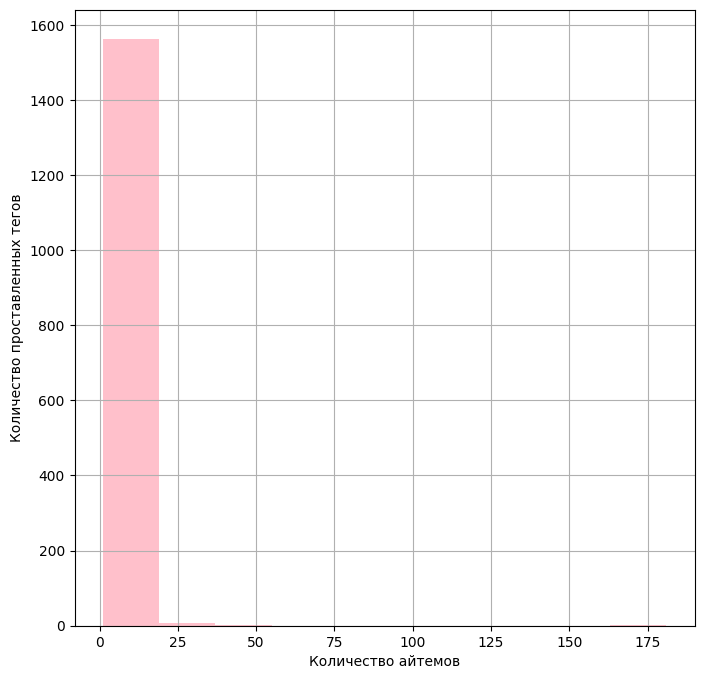

In [21]:
plt.figure(figsize=[8,8])
unique_items.hist(color = 'pink')
plt.ylabel("Количество проставленных тегов")
plt.xlabel("Количество айтемов")
plt.show()

## tf-idf преобразование в векторы

In [22]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [23]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [24]:
movies.genres

,genres
0,Adventure|Animation|Children|Comedy|Fantasy
1,Adventure|Children|Fantasy
2,Comedy|Romance
3,Comedy|Drama|Romance
4,Comedy
...,...
9737,Action|Animation|Comedy|Fantasy
9738,Animation|Comedy|Fantasy
9739,Drama
9740,Action|Animation


In [25]:
movie_genres = [change_string(value) for value in movies.genres.values]

In [26]:
movie_genres

['Adventure Animation Children Comedy Fantasy',
 'Adventure Children Fantasy',
 'Comedy Romance',
 'Comedy Drama Romance',
 'Comedy',
 'Action Crime Thriller',
 'Comedy Romance',
 'Adventure Children',
 'Action',
 'Action Adventure Thriller',
 'Comedy Drama Romance',
 'Comedy Horror',
 'Adventure Animation Children',
 'Drama',
 'Action Adventure Romance',
 'Crime Drama',
 'Drama Romance',
 'Comedy',
 'Comedy',
 'Action Comedy Crime Drama Thriller',
 'Comedy Crime Thriller',
 'Crime Drama Horror Mystery Thriller',
 'Action Crime Thriller',
 'Drama SciFi',
 'Drama Romance',
 'Drama',
 'Children Drama',
 'Drama Romance',
 'Adventure Drama Fantasy Mystery SciFi',
 'Crime Drama',
 'Drama',
 'Mystery SciFi Thriller',
 'Children Drama',
 'Crime Drama',
 'Children Comedy',
 'Comedy Romance',
 'Drama',
 'Drama War',
 'Action Crime Drama',
 'Drama',
 'Action Adventure Fantasy',
 'Comedy Drama Thriller',
 'Drama Romance',
 'Mystery Thriller',
 'Animation Children Drama Musical Romance',
 'Drama R

In [27]:
tfidf = TfidfVectorizer()
movie_train_tfidf = tfidf.fit_transform(movie_genres)
movie_train_tfidf = pd.DataFrame(movie_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [28]:
movie_train_tfidf

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.436010,0.000000,0.614603,0.000000,0.318581,0.0,0.0,0.000000,0.575034,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9738,0.000000,0.000000,0.682937,0.000000,0.354002,0.0,0.0,0.000000,0.638968,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9739,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9740,0.578606,0.000000,0.815607,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [29]:
movies = movies.drop(columns=['genres', 'title'])
movies = pd.concat([movies, movie_train_tfidf], axis=1)

In [30]:
movies

,movieId,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,1,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,0.000000,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,0.000000,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,4,0.000000,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,5,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,0.436010,0.000000,0.614603,0.000000,0.318581,0.0,0.0,0.000000,0.575034,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9738,193583,0.000000,0.000000,0.682937,0.000000,0.354002,0.0,0.0,0.000000,0.638968,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9739,193585,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9740,193587,0.578606,0.000000,0.815607,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [31]:
tag_strings = []
new_movies = []
for movie, group in tqdm(tags.groupby('movieId')):
  tag_strings.append(' '.join(set([change_string(str(s)) for s in group.tag.values])))
  new_movies.append(movie)

  0%|          | 0/1572 [00:00<?, ?it/s]

In [32]:
tfidf = TfidfVectorizer()
tag_train_tfidf = tfidf.fit_transform(tag_strings)
tag_train_tfidf = pd.DataFrame(tag_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [33]:
new_tags = pd.concat([pd.DataFrame(new_movies, columns=['movieId']), tag_train_tfidf], axis = 1)

In [34]:
new_tags

,movieId,06oscarnominatedbestmovieanimation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001like,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1568,184471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1569,187593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1570,187595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
movies_with_tags = movies.merge(new_tags, on= 'movieId')
movies_with_tags.dropna(inplace = True)
movies_with_tags.head()

,movieId,action_x,adventure_x,animation_x,children_x,comedy_x,crime_x,documentary_x,drama_x,fantasy_x,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.482990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.0,0.593662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Добавим новые фичи

In [36]:
movies_with_ratings = movies_with_tags.merge(ratings, on='movieId').drop(columns=['timestamp'])
movies_with_ratings

,movieId,action_x,adventure_x,animation_x,children_x,comedy_x,crime_x,documentary_x,drama_x,fantasy_x,...,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,userId,rating
0,1,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0
1,1,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0
2,1,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5
3,1,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5
4,1,0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48282,187595,0.418252,0.476072,0.000000,0.576575,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,4.0
48283,187595,0.418252,0.476072,0.000000,0.576575,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414,3.5
48284,187595,0.418252,0.476072,0.000000,0.576575,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,514,3.0
48285,187595,0.418252,0.476072,0.000000,0.576575,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586,5.0


In [37]:
mean_movie_rating = movies_with_ratings.groupby('movieId')['rating'].mean()
mean_user_rating = movies_with_ratings.groupby('userId')['rating'].mean()
movies_with_ratings['mean_movie_rating'] = movies_with_ratings['movieId'].apply(lambda x: mean_movie_rating[x])
movies_with_ratings['mean_user_rating'] = movies_with_ratings['userId'].apply(lambda x: mean_user_rating[x])
movies_with_ratings.head()

,movieId,action_x,adventure_x,animation_x,children_x,comedy_x,crime_x,documentary_x,drama_x,fantasy_x,...,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,userId,rating,mean_movie_rating,mean_user_rating
0,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,3.92093,4.403509
1,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0,3.92093,3.743590
2,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5,3.92093,3.543956
3,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5,3.92093,3.562500
4,1,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,0.48299,...,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5,3.92093,4.279070


In [38]:
X = movies_with_ratings.drop(columns=['rating'])
y = pd.DataFrame(movies_with_ratings['rating'])
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size = 0.2, random_state = 21)

In [39]:
model = Ridge(alpha=0.1)
model.fit(X_train,y_train )

Ridge(alpha=0.1)

In [40]:
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

np.float64(0.8372297363654162)

## Без tf-idf

In [41]:
X = movies_with_ratings[['movieId', 'userId', 'mean_movie_rating', 'mean_user_rating']]
y = movies_with_ratings['rating']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

np.float64(0.7961733250369376)

Были произведены преобразования данных в вектора (TF-IDF) для признаков genre и tag. Также были добавлены новые признаки средняя оценка для фильма и средняя оценка пользователя. На основе них были обучены линейные модели как с использованием преобразованных данных TF-IDF, так и только на основании средних оценок. в качестве метрики для оценки качества модели использовался RMSE


    модель с TF-IDF: RMSE = 0.8372297363654162
    модель без TF-IDF: RMSE = 0.7961733250369376

Можно сказать, что мы получили достаточно неплохое качество модели для предсказания рейтинга, выставленное пользователем фильму.